In [2]:
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install pyspark
!pip install yellowbrick

In [3]:
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark import SparkContext as sc
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import udf,col
import os
# tools
import re
import math
import json
import requests
import itertools
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
import string
import random

In [4]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
#from pyspark.sql.functions import split as splitsp
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
from sklearn import decomposition

In [5]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark Naive Bayes CountVectorizer") \
        .getOrCreate()
    return spark
spark = init_spark()

In [7]:
'''
Read Lemma data
'''
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType

data = spark.read.csv("lemma-100days-wsbdata.csv", header=True)
function_array = udf(lambda r: r.split("|"), ArrayType(StringType()))
function_toNumerical = udf(lambda r: int(r), IntegerType())
text_lemmas = data.withColumn('finished_lemmas', function_array('text')).drop('text').withColumn('label', function_toNumerical('label'))
print(text_lemmas.count())
text_lemmas.show()

1144
+------+-----+--------------------+
|    id|label|     finished_lemmas|
+------+-----+--------------------+
|ks1tzw|    0|[all, right, all,...|
|ksjhuu|    0|[bldr, $, pt, pos...|
|kt79b2|    0|[we, might, be, h...|
|kt9enf|    0|[bear, feast, on,...|
|ktbu75|    0|[so, today, i, go...|
|ktfori|    0|[what, a, week, i...|
|kup2e2|    1|[start, to, feel,...|
|kurzyz|    0|[i, honestly, don...|
|kusng4|    0|[soi, recently, o...|
|kuku2g|    1|[nio, be, disrupt...|
|kutslm|    1|[listen, up, you,...|
|kv7k8k|    0|[have, anyone, no...|
|kvarzs|    0|[now, that, the, ...|
|kvcard|    0|[we, all, know, t...|
|kvcmhk|    1|[it, do, not, dil...|
|kva2kt|    0|[we, know, you, l...|
|kvacad|    1|[so, i, hear, you...|
|kvcimd|    1|[look, at, hour, ...|
|kvtk4b|    1|[giga, berain, co...|
|kw2vwm|    1|[see, the, end, o...|
+------+-----+--------------------+
only showing top 20 rows



In [8]:
'''
Get the Corpus.
Removing stop words from the text lemmas. 
'''
remover = StopWordsRemover(inputCol="finished_lemmas", outputCol="text")
filtered_df = remover.transform(text_lemmas)
filtered_df.show()

+------+-----+--------------------+--------------------+
|    id|label|     finished_lemmas|                text|
+------+-----+--------------------+--------------------+
|ks1tzw|    0|[all, right, all,...|[right, artist, f...|
|ksjhuu|    0|[bldr, $, pt, pos...|[bldr, $, pt, pos...|
|kt79b2|    0|[we, might, be, h...|[might, hear, fir...|
|kt9enf|    0|[bear, feast, on,...|[bear, feast, low...|
|ktbu75|    0|[so, today, i, go...|[today, go, games...|
|ktfori|    0|[what, a, week, i...|[week, steel, big...|
|kup2e2|    1|[start, to, feel,...|[start, feel, rea...|
|kurzyz|    0|[i, honestly, don...|[honestly, dont, ...|
|kusng4|    0|[soi, recently, o...|[soi, recently, o...|
|kuku2g|    1|[nio, be, disrupt...|[nio, disrupt, te...|
|kutslm|    1|[listen, up, you,...|[listen, degenera...|
|kv7k8k|    0|[have, anyone, no...|[anyone, notice, ...|
|kvarzs|    0|[now, that, the, ...|[boy, rc, get, po...|
|kvcard|    0|[we, all, know, t...|[know, 🌈🐻s, cal...|
|kvcmhk|    1|[it, do, not, dil..

In [9]:
'''
Create Document-Term Matrix by vectorizing the filtered text.
- returns the features column: (total nb of words, indices of each word in total vocab, count of each word)
'''
to_vectorize = filtered_df.select('id', 'label', 'text')
cv = CountVectorizer(inputCol="text", outputCol="features")
model_vec = cv.fit(to_vectorize)
result_vec = model_vec.transform(to_vectorize)
print("Total count of vocabulary:", len(model_vec.vocabulary))
result_vec.show()

Total count of vocabulary: 10932
+------+-----+--------------------+--------------------+
|    id|label|                text|            features|
+------+-----+--------------------+--------------------+
|ks1tzw|    0|[right, artist, f...|(10932,[1,2,4,7,8...|
|ksjhuu|    0|[bldr, $, pt, pos...|(10932,[3,5,6,7,9...|
|kt79b2|    0|[might, hear, fir...|(10932,[25,55,77,...|
|kt9enf|    0|[bear, feast, low...|(10932,[1,4,6,7,8...|
|ktbu75|    0|[today, go, games...|(10932,[1,4,8,25,...|
|ktfori|    0|[week, steel, big...|(10932,[3,4,5,7,8...|
|kup2e2|    1|[start, feel, rea...|(10932,[3,8,13,30...|
|kurzyz|    0|[honestly, dont, ...|(10932,[8,15,16,1...|
|kusng4|    0|[soi, recently, o...|(10932,[0,1,4,11,...|
|kuku2g|    1|[nio, disrupt, te...|(10932,[4,11,14,1...|
|kutslm|    1|[listen, degenera...|(10932,[4,5,11,12...|
|kv7k8k|    0|[anyone, notice, ...|(10932,[0,1,19,26...|
|kvarzs|    0|[boy, rc, get, po...|(10932,[1,5,6,8,1...|
|kvcard|    0|[know, 🌈🐻s, cal...|(10932,[0,1,3,4,5...|


In [10]:
selectedData = result_vec.select('id', 'label','features', 'text')
selectedData.show(truncate=True)

+------+-----+--------------------+--------------------+
|    id|label|            features|                text|
+------+-----+--------------------+--------------------+
|ks1tzw|    0|(10932,[1,2,4,7,8...|[right, artist, f...|
|ksjhuu|    0|(10932,[3,5,6,7,9...|[bldr, $, pt, pos...|
|kt79b2|    0|(10932,[25,55,77,...|[might, hear, fir...|
|kt9enf|    0|(10932,[1,4,6,7,8...|[bear, feast, low...|
|ktbu75|    0|(10932,[1,4,8,25,...|[today, go, games...|
|ktfori|    0|(10932,[3,4,5,7,8...|[week, steel, big...|
|kup2e2|    1|(10932,[3,8,13,30...|[start, feel, rea...|
|kurzyz|    0|(10932,[8,15,16,1...|[honestly, dont, ...|
|kusng4|    0|(10932,[0,1,4,11,...|[soi, recently, o...|
|kuku2g|    1|(10932,[4,11,14,1...|[nio, disrupt, te...|
|kutslm|    1|(10932,[4,5,11,12...|[listen, degenera...|
|kv7k8k|    0|(10932,[0,1,19,26...|[anyone, notice, ...|
|kvarzs|    0|(10932,[1,5,6,8,1...|[boy, rc, get, po...|
|kvcard|    0|(10932,[0,1,3,4,5...|[know, 🌈🐻s, cal...|
|kvcmhk|    1|(10932,[0,17,25,4..

In [ ]:
'''
K-means clustering with PySpark
'''

In [11]:
# train k-means
kmeans = KMeans().setK(2).setSeed(10)
model = kmeans.fit(selectedData)

# make predictions
predictions = model.transform(selectedData)

# evaluate clustering
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()

#probably model.data? [[0,10,20],[30,40,60]......]
# for : for: print vol[0],vol[10]
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.7376622389572465
Cluster Centers: 
[0.87922705 0.87149758 0.57681159 ... 0.00096618 0.         0.00096618]
[7.13761468 4.73394495 7.02752294 ... 0.         0.00917431 0.        ]


In [12]:
data_pd = selectedData.select('features').rdd
data_list = data_pd.map(lambda row: list(row['features'])).collect()

In [14]:
'''
K-means with Scikit-learn
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Instantiate the KMeans models
km = KMeans(n_clusters=2, random_state=10)

# Fit the KMeans model
cluster_labels = km.fit_predict(data_list)

# Calculate Silhoutte Score
score = silhouette_score(data_list, km.labels_, metric='euclidean')

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(data_list, cluster_labels)

print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.562


In [ ]:
'''
https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
'''
# from yellowbrick.cluster import SilhouetteVisualizer

# fig, ax = plt.subplots(2, 2, figsize=(15,8))
# for i in [2, 3, 4, 5]:
#     '''
#     Create KMeans instance for different number of clusters
#     '''
#     km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
#     q, mod = divmod(i, 2)
#     '''
#     Create SilhouetteVisualizer instance with KMeans instance
#     Fit the visualizer
#     '''
#     visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
#     visualizer.fit(X)

In [18]:
X = data_list
np_X = np.array(X)
print(np_X.shape)
pca = decomposition.PCA(n_components=2)
pca.fit(np_X)
reduced_ = pca.transform(np_X)
reduced_.shape

(1144, 10932)


(1144, 2)

In [20]:
X = data_list
np_X = np.array(X)
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)
svd.fit(np_X)
svd_concatenated = svd.transform(np_X)
from sklearn.manifold import TSNE
TSNE_ = TSNE(n_components=2,learning_rate=250,n_iter=5000)
reduced_=TSNE_.fit_transform(svd_concatenated)

For n_clusters = 2 The average silhouette_score is : 0.41819674
Silhouetter Score: 0.418
0
1
For n_clusters = 3 The average silhouette_score is : 0.3830156
Silhouetter Score: 0.383
0
1
2
For n_clusters = 4 The average silhouette_score is : 0.3740304
Silhouetter Score: 0.374
0
1
2
3
For n_clusters = 5 The average silhouette_score is : 0.36532122
Silhouetter Score: 0.365
0
1
2
3
4
For n_clusters = 6 The average silhouette_score is : 0.35366374
Silhouetter Score: 0.354
0
1
2
3
4
5


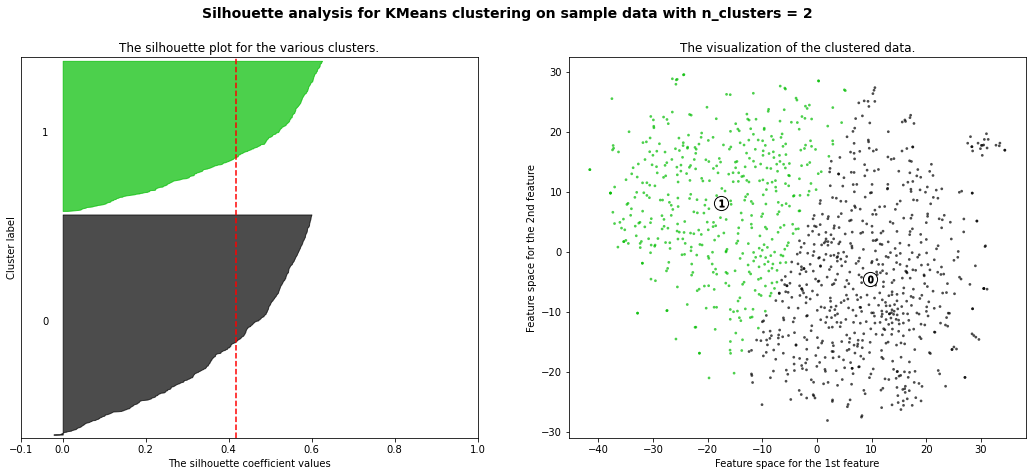

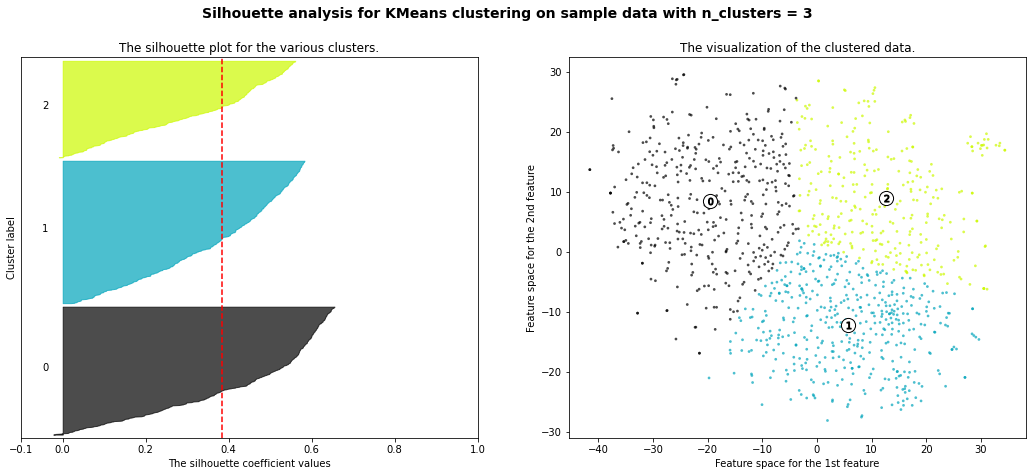

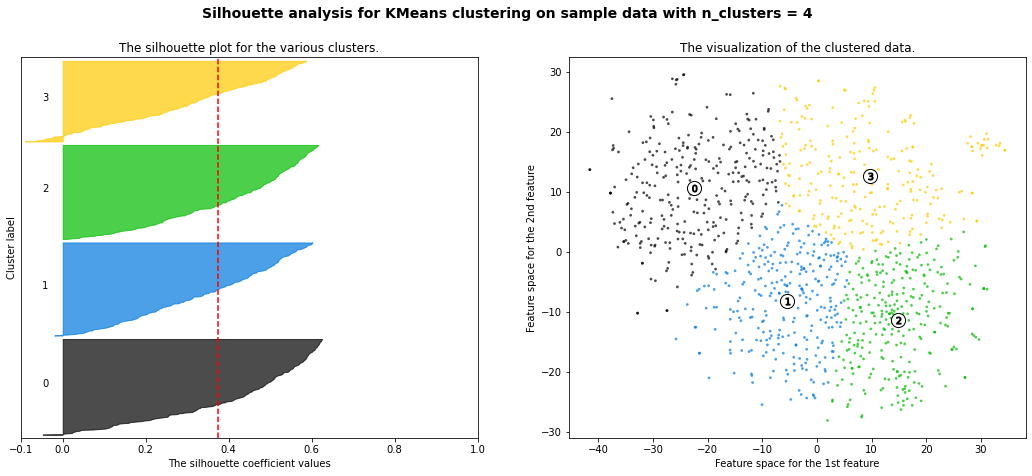

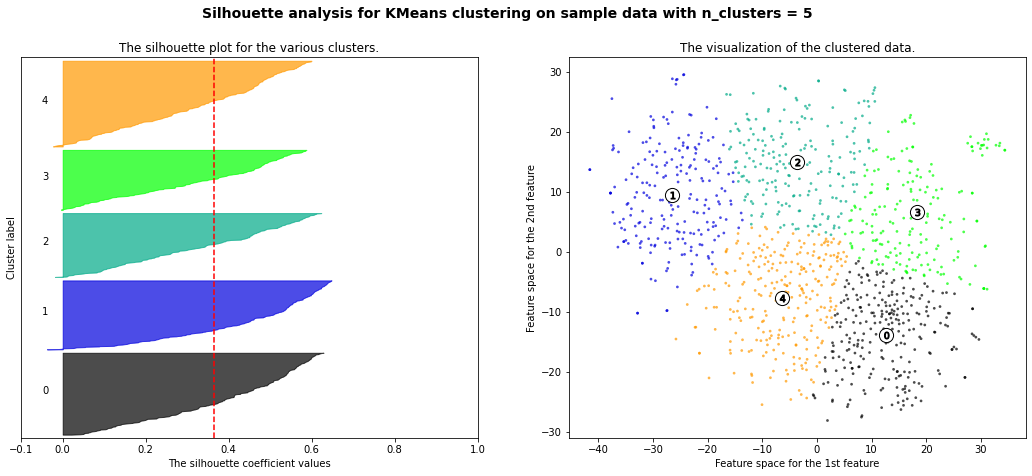

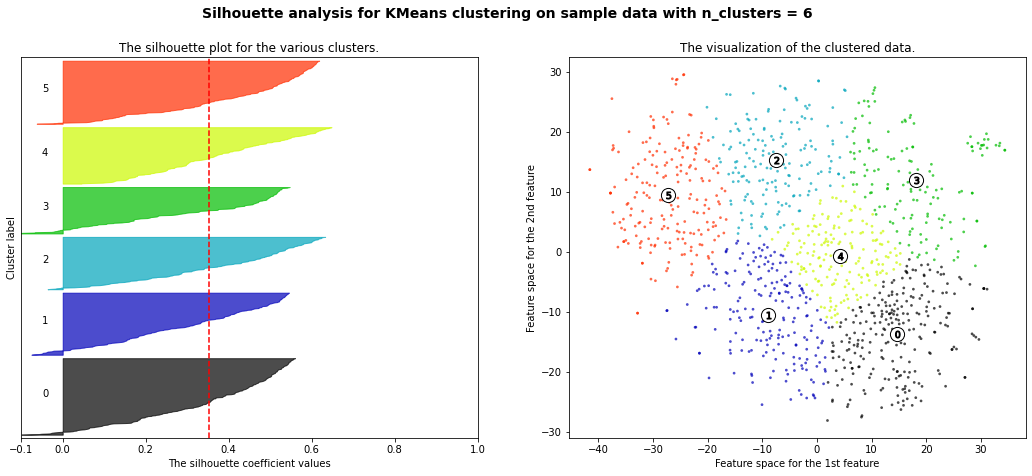

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(reduced_) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.

    # Instantiate the KMeans models
    km = KMeans(n_clusters=n_clusters, random_state=10)

    # Fit the KMeans model
    cluster_labels = km.fit_predict(reduced_)

    # Calculate Silhoutte Score
    silhouette_avg = silhouette_score(reduced_, km.labels_, metric='euclidean')
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(reduced_, cluster_labels)

    print('Silhouetter Score: %.3f' % silhouette_avg)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_[:, 0], reduced_[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
#selectedData.show()
np_array = selectedData.rdd.map(lambda x : np.array(x.features.toArray())).collect()
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = 3, random_state = 42,max_iter=500)
lda.fit(np_array)

In [ ]:
for index, topic in enumerate(lda.components_):
    print(f'Top 15 words for Topic #{index}')
    print([model_vec.vocabulary[i] for i in topic.argsort()[-15:]])
    print('\n')

In [ ]:
result = lda.transform(np_array)

In [ ]:
largest_topic = [ np.argmax(i) for i in result]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)